In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import random
from sklearn.cluster import DBSCAN
import webcolors
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
df_transactions_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +
                                    "Thalia_transactions_ohne_vorname.csv")

df_history_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +
                                    "Thalia_history_ohne_vorname.csv")

In [3]:
df_privatkunden_iids = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/" +
                                    "privatkunden.iid.thalia.csv", index_col = [0])

# 1. Daten bereinigen

#### 1.1 Transaktions-Daten bereinigen

In [4]:
df_t_bereinigt = df_transactions_wofirstname[["iid", "key", "attrtype", "status", "pricetotal", "createdprovider"]]
#df_t_bereinigt["pricetotal"] = pd.to_numeric(df_t_bereinigt["pricetotal"], errors = "coerce")
df_t_bereinigt = df_t_bereinigt.query('attrtype == "TI"')
df_t_bereinigt = df_t_bereinigt.query('status == "Buchung" or status == "Order"')
df_t_bereinigt = df_t_bereinigt.query('pricetotal >= 0.01')
#searchfor = ['TEST']
#searchfor = ['TEST', 'JET', "WS"]
#df_t_bereinigt = df_t_bereinigt[~df_t_bereinigt["key"].str.contains('|'.join(searchfor))]
df_t_bereinigt.head()

,iid,key,attrtype,status,pricetotal,createdprovider
1,100279806,JET_1_a1179092,TI,Order,20.5,20220630111759
4,262428540,JET_1_a1179095,TI,Order,5.0,20220630113800
5,262429050,JET_1_a1179096,TI,Order,20.5,20220630115500
7,262429050,JET_1_a1179096,TI,Order,9.0,20220630115500
10,262429655,JET_1_a1179100,TI,Order,55.0,20220630121500


# 2. Datum als datetime type und rename

#### 2.1 Createdprovider als datetime type und rename
#### 2.2 Status, key und attrtype droppen für Transaktionsdaten, da redundant

In [5]:
df_t_datetime = df_t_bereinigt
df_t_datetime["createdprovider"] = pd.to_datetime(df_t_datetime['createdprovider'], format='%Y%m%d%H%M%S')
df_t_datetime.rename(columns = {"createdprovider" : "date"}, inplace = True)

In [6]:
df_t_ohne_redundanz = df_t_datetime[["iid", "pricetotal", "date"]]
df_t_ohne_redundanz.head()

,iid,pricetotal,date
1,100279806,20.5,2022-06-30 11:17:59
4,262428540,5.0,2022-06-30 11:38:00
5,262429050,20.5,2022-06-30 11:55:00
7,262429050,9.0,2022-06-30 11:55:00
10,262429655,55.0,2022-06-30 12:15:00


# 3. FirstTrans einfügen und durchschn. Ausgaben pro Monat in letzten 5 Jahre (oder seit FirstTrans)

In [7]:
list_t_first_trans = df_t_ohne_redundanz.groupby(["iid"])["date"].agg("min")
df_t_first_trans = list_t_first_trans.to_frame()
df_t_first_trans = df_t_first_trans.rename(columns = {"date" : "FirstTrans"})
df_t3 = pd.merge(df_t_ohne_redundanz, df_t_first_trans, on=["iid"])
df_t3.head()

,iid,pricetotal,date,FirstTrans
0,100279806,20.5,2022-06-30 11:17:59,2020-09-04 20:58:00
1,100279806,25.0,2022-09-24 18:23:26,2020-09-04 20:58:00
2,100279806,25.0,2022-09-24 18:23:26,2020-09-04 20:58:00
3,100279806,28.9,2020-09-04 20:58:00,2020-09-04 20:58:00
4,100279806,28.9,2020-09-04 20:58:00,2020-09-04 20:58:00


# 4. Falls FirstTrans vor einfuehrung - 5 Jahre, durch einfuehrung - 5 Jahre ersetzen

In [8]:
einfuehrung = pd.to_datetime(df_history_wofirstname["creation"].min(), format='%Y%m%d%H%M%S')
einfuehrung

Timestamp('2020-04-02 14:00:03')

In [9]:
datum_vor_5_jahren = einfuehrung - timedelta(days=365*5)
datum_vor_5_jahren

Timestamp('2015-04-04 14:00:03')

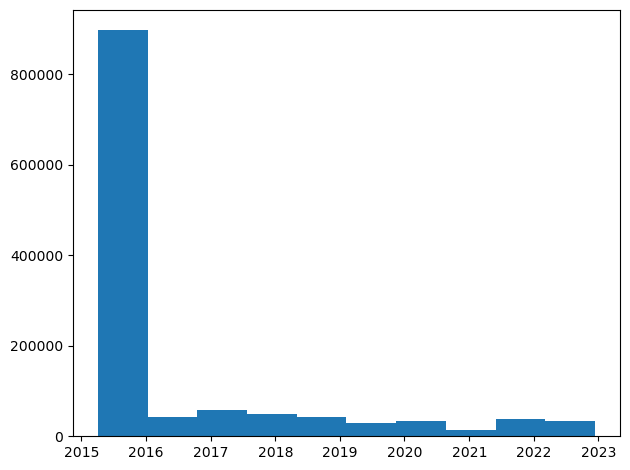

In [10]:
df_t3.loc[df_t3["FirstTrans"] <= datum_vor_5_jahren, "FirstTrans"] = datum_vor_5_jahren
#[df_t3["FirstTrans"] <= einfuehrung]["FirstTrans"] = datum_vor_5_jahren
fig, ax = plt.subplots()
ax.hist(df_t3["FirstTrans"])
plt.tight_layout()

# 5. Durchschnittl. Ausgaben pro Monat in letzte 5 Jahre 

In [11]:
df_t_5_Jahre_davor = df_t3.query('@datum_vor_5_jahren <= date <= @einfuehrung')
df_t_5_Jahre_davor.head()

,iid,pricetotal,date,FirstTrans
16,100520650,11.4,2020-03-02 10:00:00,2015-04-04 14:00:03
22,100520650,18.9,2016-11-04 14:00:05,2015-04-04 14:00:03
23,100520650,18.9,2017-03-09 10:30:00,2015-04-04 14:00:03
24,100520650,20.6,2017-04-22 16:34:46,2015-04-04 14:00:03
25,100520650,18.0,2017-04-22 16:34:46,2015-04-04 14:00:03


#### 5.1 Einführung Spalte Monate seit FirstTrans

In [12]:
df_t_5_Jahre_davor_vergMonate = df_t_5_Jahre_davor
df_t_5_Jahre_davor_vergMonate["vergangeneMonate"] = (einfuehrung - df_t_5_Jahre_davor_vergMonate["FirstTrans"]) / timedelta(days=30)
df_t_5_Jahre_davor_vergMonate.head()

C:\Users\felix.oechslein\AppData\Local\Temp\ipykernel_14072\2357961293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_5_Jahre_davor_vergMonate["vergangeneMonate"] = (einfuehrung - df_t_5_Jahre_davor_vergMonate["FirstTrans"]) / timedelta(days=30)


,iid,pricetotal,date,FirstTrans,vergangeneMonate
16,100520650,11.4,2020-03-02 10:00:00,2015-04-04 14:00:03,60.833333
22,100520650,18.9,2016-11-04 14:00:05,2015-04-04 14:00:03,60.833333
23,100520650,18.9,2017-03-09 10:30:00,2015-04-04 14:00:03,60.833333
24,100520650,20.6,2017-04-22 16:34:46,2015-04-04 14:00:03,60.833333
25,100520650,18.0,2017-04-22 16:34:46,2015-04-04 14:00:03,60.833333


#### 5.2 Berechnung des CV und CV pro Monat

In [13]:
df_t_5_Jahre_davor_komplett = df_t_5_Jahre_davor_vergMonate
df_t_5_Jahre_davor_komplett = df_t_5_Jahre_davor_komplett.groupby(['iid', 'vergangeneMonate'])['pricetotal'].agg('sum').to_frame().reset_index()
df_t_5_Jahre_davor_komplett.rename(columns = {"pricetotal":"CV_letzte_5_jahre"}, inplace = True)
df_t_5_Jahre_davor_komplett["durchschnittLetzte5"] = df_t_5_Jahre_davor_komplett["CV_letzte_5_jahre"] / df_t_5_Jahre_davor_komplett["vergangeneMonate"]
df_t_5_Jahre_davor_komplett.head()

,iid,vergangeneMonate,CV_letzte_5_jahre,durchschnittLetzte5
0,100009615,19.005742,131.6,6.924223
1,100011954,60.833333,763.6,12.552329
2,100013945,2.863543,74.7,26.086566
3,100017834,2.773010,15.0,5.409284
4,100022607,2.625005,41.0,15.619020


# 6. DBScan mit durchschnittLetzte5 und vergangeneMonate

In [15]:
X = df_t_5_Jahre_davor_komplett[df_t_5_Jahre_davor_komplett["durchschnittLetzte5"] < 300][["vergangeneMonate", "durchschnittLetzte5"]]
X.head()

,vergangeneMonate,durchschnittLetzte5
0,19.005742,6.924223
1,60.833333,12.552329
2,2.863543,26.086566
3,2.773010,5.409284
4,2.625005,15.619020


In [62]:
dbscan = DBSCAN(eps=2, min_samples=300)

In [63]:
clusters = dbscan.fit_predict(X)
X['cluster'] = clusters
labels = dbscan.labels_

# Eindeutige Cluster-Labels berechnen
unique_labels = np.unique(labels)
print("Unique labels:" + str(unique_labels))

Unique labels:[-1  0  1  2  3  4  5  6  7  8  9 10]


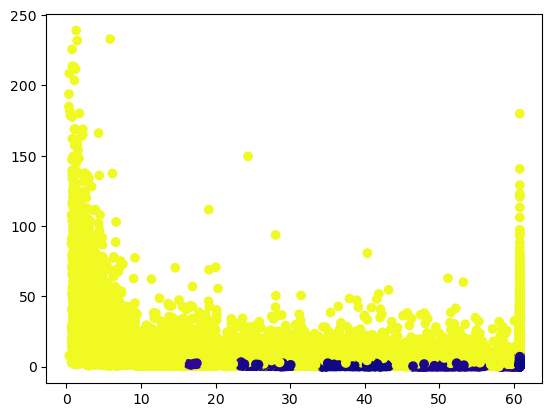

In [60]:
# Verwendete Farbpalette definieren
colors = plt.get_cmap('plasma').colors
color_names = mcolors.CSS4_COLORS.keys()

# Namen zu den verwendeten Farben
color_names_used  = []
for color, name in zip(colors, color_names):
    color_names_used.append(name)

# Farben für jedes Cluster zuweisen
color_map = []
for label in labels:
    color_map.append(colors[label])

# Datenpunkte plotten
plt.scatter(X["vergangeneMonate"], X["durchschnittLetzte5"], c=color_map)

plt.show()

C:\Users\felix.oechslein\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


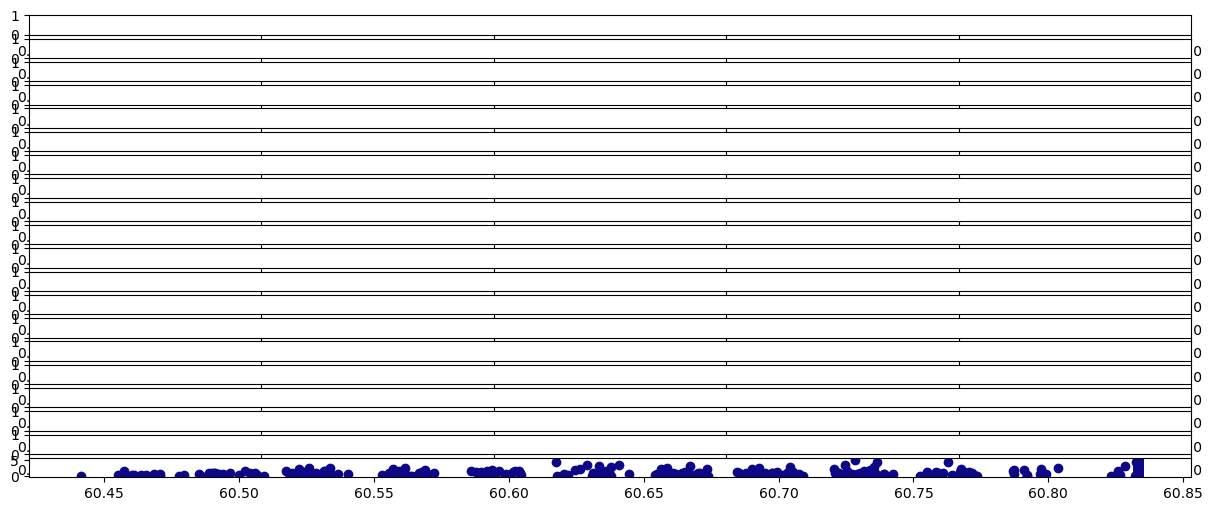

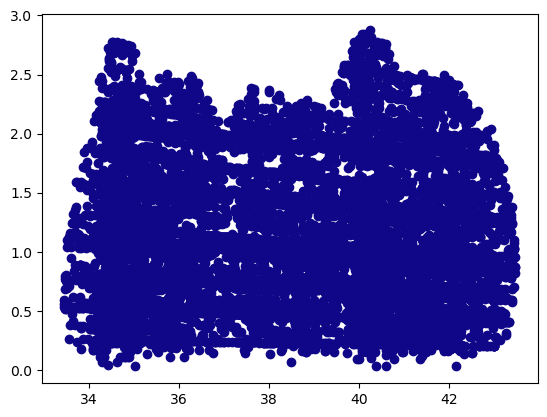

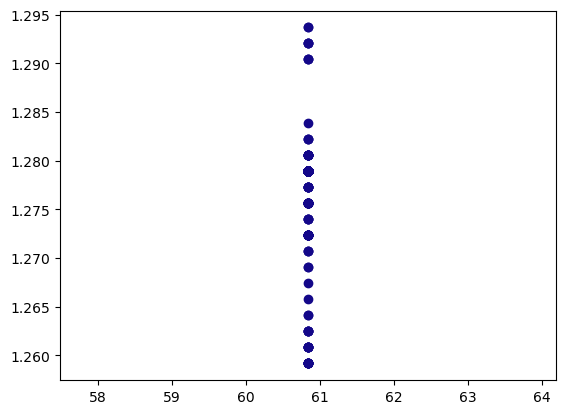

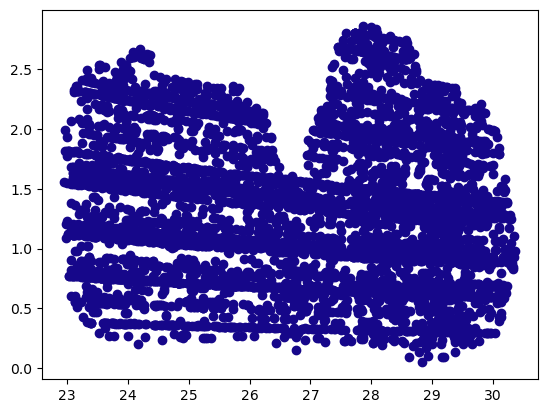

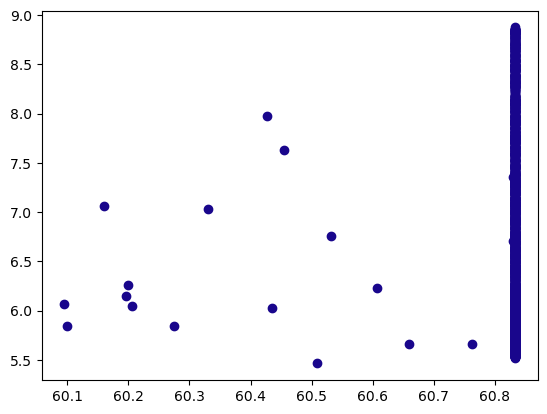

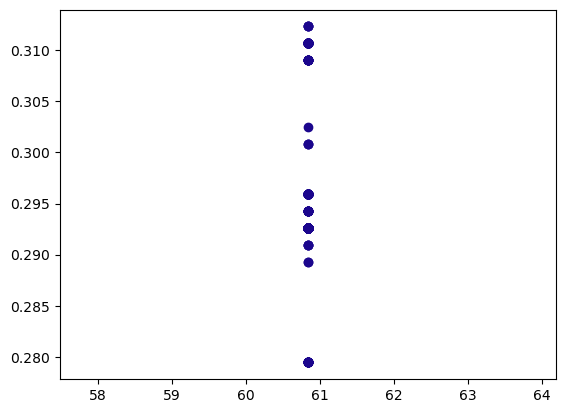

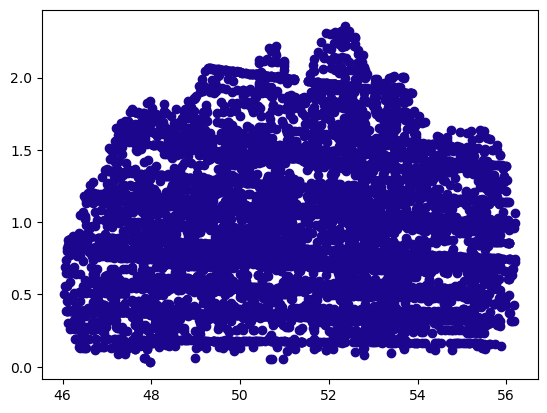

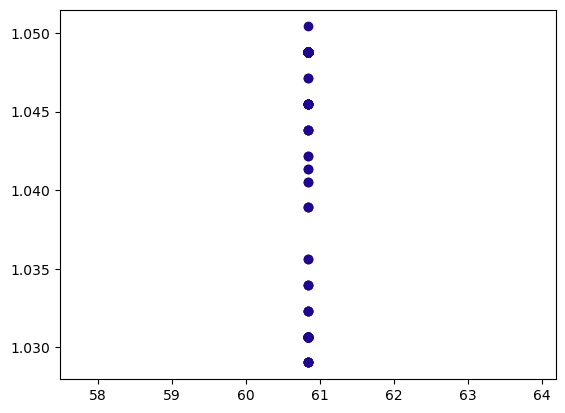

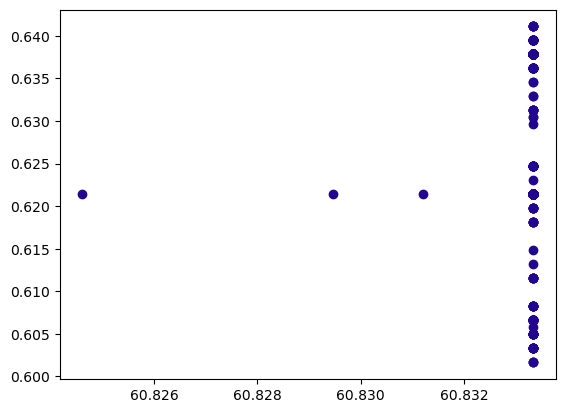

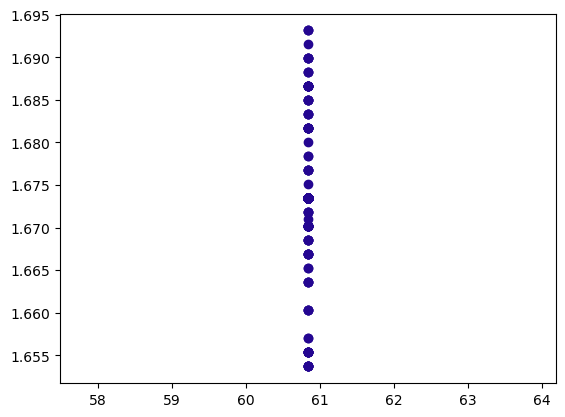

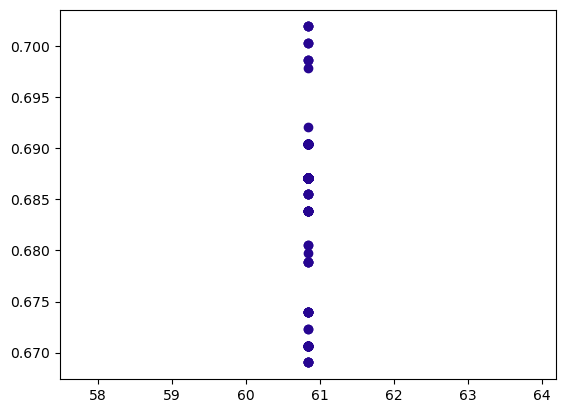

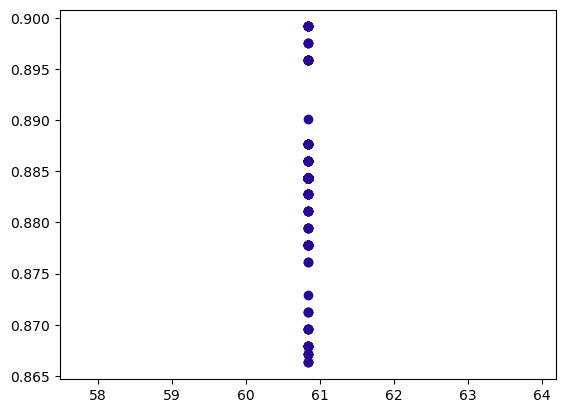

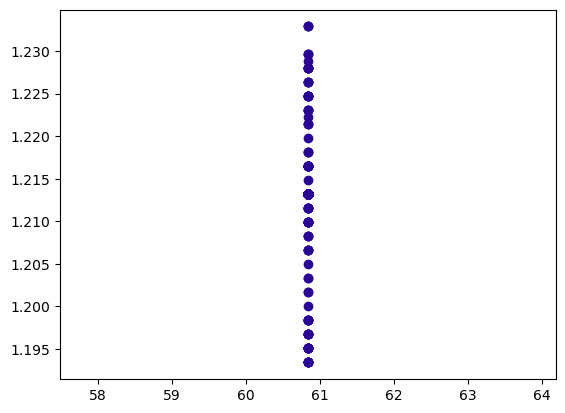

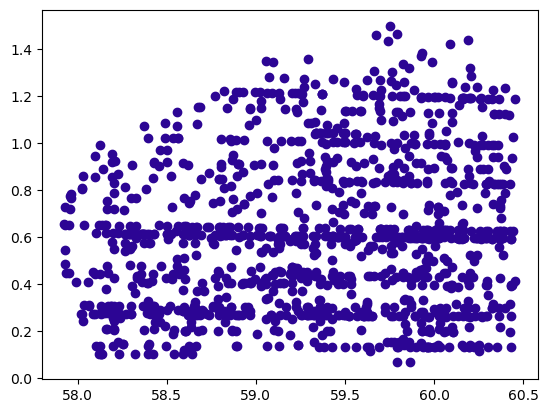

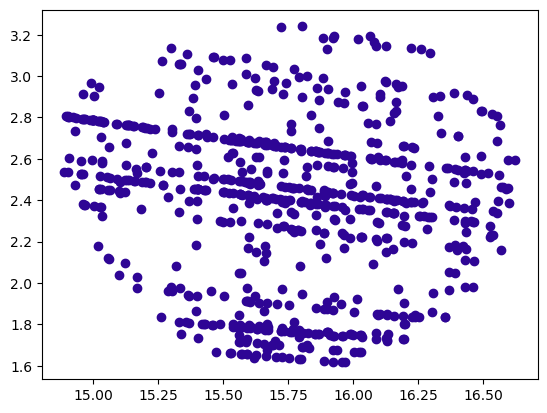

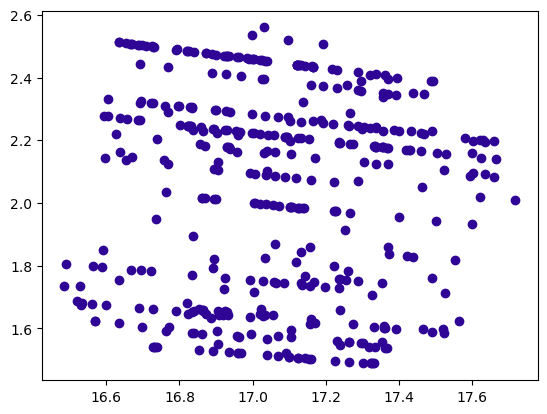

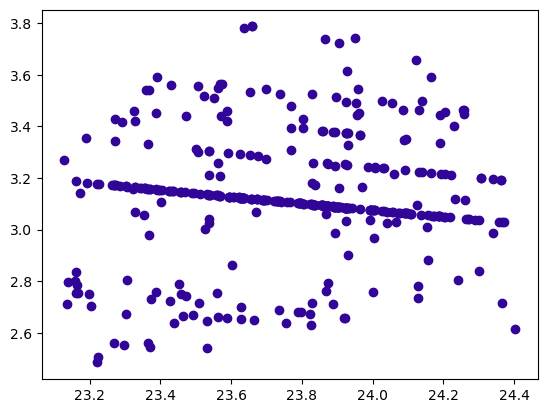

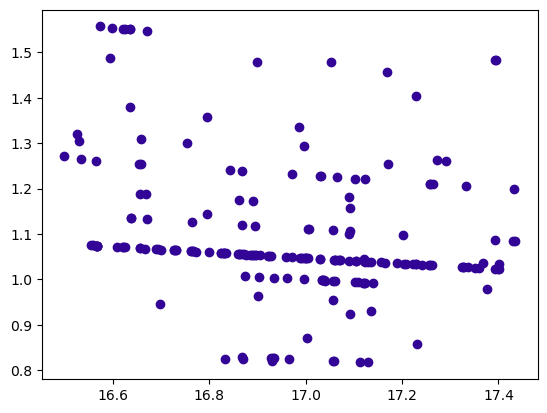

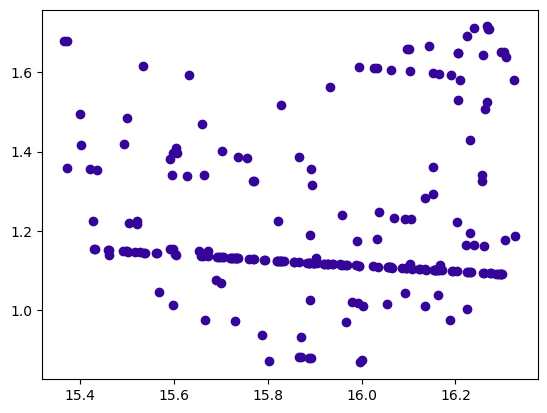

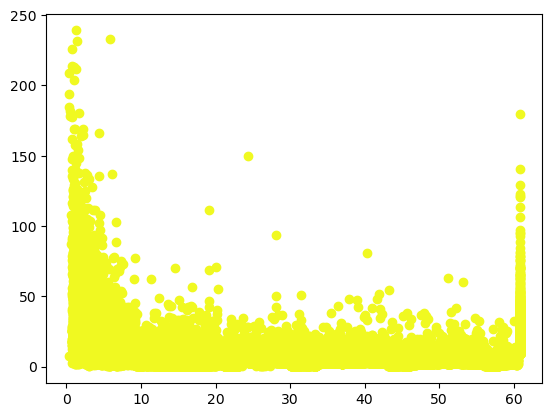

In [61]:
fig, axs = plt.subplots(len(unique_labels), 1, figsize=(15, 6), tight_layout=True)
axs = axs.ravel()

for cluster in set(X['cluster']):
    Xaxis = X[X["cluster"] == cluster]["vergangeneMonate"]
    Yaxis = X[X["cluster"] == cluster]["durchschnittLetzte5"]
    plt.scatter(Xaxis, Yaxis, color = colors[cluster])
    #axs[cluster].set_xlabel("cluster" + cluster)
    plt.show()

In [57]:
# Interpretieren Sie die erstellten Cluster, indem Sie die Mittelwerte der Transaktionspreise und die Häufigkeit der Transaktionen für jeden Cluster untersuchen
for cluster in set(X['cluster']):
    print("Cluster", cluster)
    print("Pukte im Cluster:", X.loc[X['cluster'] == cluster, 'durchschnittLetzte5'].count())
    print("Farbe:", color_names_used[cluster])
    print("Durchschnitt vom Durchschnitt der letzten 5 Jahre:", X.loc[X['cluster'] == cluster, 'durchschnittLetzte5'].mean())
    print("Durchschnitt vergangene Monate: ", X.loc[X['cluster'] == cluster, 'vergangeneMonate'].mean())

Cluster 0
Pukte im Cluster: 12772
Farbe: aliceblue
Durchschnitt vom Durchschnitt der letzten 5 Jahre: 1.9833754264308787
Durchschnitt vergangene Monate:  60.82894618376394
Cluster 1
Pukte im Cluster: 349
Farbe: antiquewhite
Durchschnitt vom Durchschnitt der letzten 5 Jahre: 1.2772367233190771
Durchschnitt vergangene Monate:  60.83333333333324
Cluster 2
Pukte im Cluster: 504
Farbe: aqua
Durchschnitt vom Durchschnitt der letzten 5 Jahre: 0.2951696020874079
Durchschnitt vergangene Monate:  60.8333333333329
Cluster 3
Pukte im Cluster: 334
Farbe: aquamarine
Durchschnitt vom Durchschnitt der letzten 5 Jahre: 1.044145681240261
Durchschnitt vergangene Monate:  60.8333333333333
Cluster 4
Pukte im Cluster: 648
Farbe: azure
Durchschnitt vom Durchschnitt der letzten 5 Jahre: 0.6249380808413039
Durchschnitt vergangene Monate:  60.833310619212966
Cluster 5
Pukte im Cluster: 416
Farbe: beige
Durchschnitt vom Durchschnitt der letzten 5 Jahre: 1.67335155426766
Durchschnitt vergangene Monate:  60.833333

# 7. kmeans mit durchschnittLetzte5 und vergangeneMonate

In [70]:
X_means = df_t_5_Jahre_davor_komplett[df_t_5_Jahre_davor_komplett["durchschnittLetzte5"] < 300][["vergangeneMonate", "durchschnittLetzte5"]]
X_means.head()

,vergangeneMonate,durchschnittLetzte5
0,19.005742,6.924223
1,60.833333,12.552329
2,2.863543,26.086566
3,2.773010,5.409284
4,2.625005,15.619020


In [79]:
# K-Means-Modell erstellen
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_means)

# Vorhersagen der Clusterzugehörigkeiten
labels = kmeans.predict(X_means)

# Clusterzentren berechnen
cluster_centers = kmeans.cluster_centers_

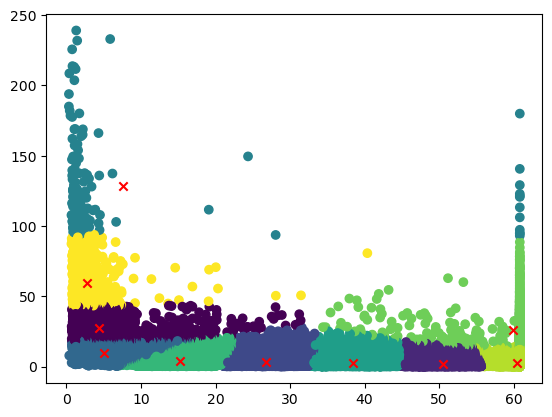

In [80]:
# Datenpunkte in verschiedenen Farben nach Cluster zeichnen
plt.scatter(X_means["vergangeneMonate"], X_means["durchschnittLetzte5"], c=labels)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='r')
plt.show()

# 8. hierarchical clustering mit durchschnittLetzte5 und vergangeneMonate

In [90]:
X_hierarchical = df_t_5_Jahre_davor_komplett[df_t_5_Jahre_davor_komplett["durchschnittLetzte5"] < 300][["vergangeneMonate", "durchschnittLetzte5"]]
X_hierarchical.head()

,vergangeneMonate,durchschnittLetzte5
0,19.005742,6.924223
1,60.833333,12.552329
2,2.863543,26.086566
3,2.773010,5.409284
4,2.625005,15.619020


In [91]:
X_hierarchical_sample = X_hierarchical.sample(n = 10000)

In [94]:
X_hierarchical_sample.head()

,vergangeneMonate,durchschnittLetzte5
11440,60.833333,2.561096
81604,4.898913,2.857777
41009,39.801297,0.447222
85048,2.823797,21.177156
70035,15.992663,9.979576


In [92]:
# Hierarchisches Clustering berechnen
Z = linkage(X_hierarchical_sample, method='average')

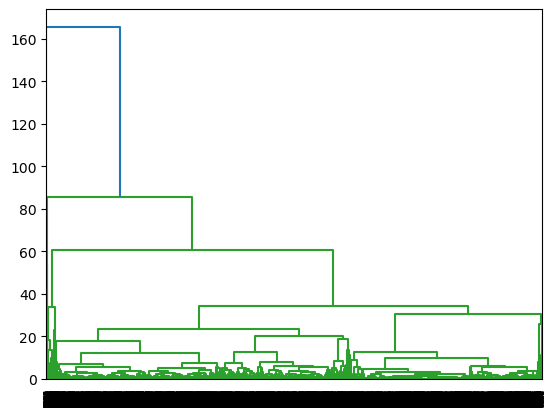

In [93]:
# Dendrogramm zeichnen
dendrogram(Z)
plt.show()

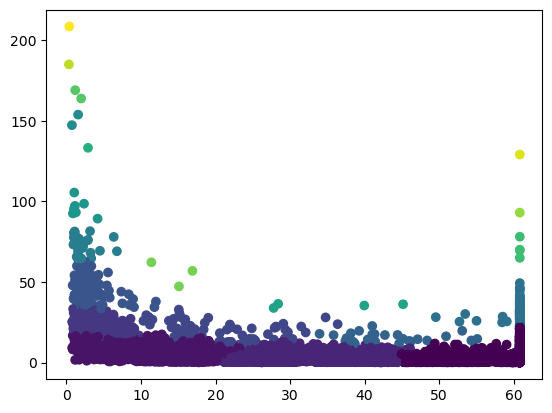

In [96]:
# Festlegen der Anzahl von Clustern
k = 20
clusters = cut_tree(Z, n_clusters=[k])

# Datenpunkte in verschiedenen Farben nach Cluster zeichnen
plt.scatter(X_hierarchical_sample["vergangeneMonate"], X_hierarchical_sample["durchschnittLetzte5"], c=clusters.flatten())
plt.show()